<a href="https://colab.research.google.com/github/avprils/Lexicon-Based-for-Sentiment-Analysis/blob/main/Sentiment_Analysis_using_Unsupervised_Lexicon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
import tweepy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

In [ ]:
# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

In [ ]:
# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

In [ ]:
from wordcloud import WordCloud 

#Getting Twitter API and Access Tokens

In [ ]:
consumer_key = 'Fnd9AAdBBn7DiohIdVDHAjbID'
consumer_secret = 'ogbboFLndF52HSm83y0Iqp92FJ4ZUrbB0F2XfHht3VP84ufkAf' 
access_token = '2601458342-Tp6HheOUzhYY6lQdxAKmrDB2z10Nse0PeV3eYx8'
access_token_secret ='auCntDSiZPUQqtsQRZUN0r7IAeWduFWaRPmUuW7F3VGt7'

##Fetch Tweets (Twitter API using 'TweePy')

In [ ]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

###Fetching tweets for 'Omnibuslaw'

In [ ]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('Omnibuslaw', maxTweets=1000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 72 tweets
Downloaded 112 tweets
Downloaded 193 tweets
Downloaded 267 tweets
Downloaded 363 tweets
Downloaded 463 tweets
Downloaded 563 tweets
Downloaded 656 tweets
Downloaded 747 tweets
Downloaded 847 tweets
Downloaded 947 tweets
Downloaded 1047 tweets
tweets_df Shape - (560, 1)


,tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj..."
1,Indonesian labour unions are challenging the #...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...
4,hari ini tolak omnibuslaw besok dukung heheee ...
5,@__teruss @demokrasiambyar Omnibuslaw gimana?
6,RT @WartaEkonomi: TaniHub: Omnibuslaw dan Vaks...
7,TaniHub: Omnibuslaw dan Vaksin Ciptakan Angin ...
8,@PresidenKopi Apa guna tuh omnibuslaw ? Pret l...
9,@KIMlELIP KENAPA JADI OMNIBUSLAW


##Text Preprocessing

####a. Removing'@username'

Here, we can see that at many places we have '@names', which is of no use since it does not have any meaning, So it needs to be removed.

In [ ]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

In [ ]:
# We are keeping cleaned tweets in a new column called 'clean_tweets'

tweets_df['clean_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], " *RT* | *@[\w]*")

tweets_df.head(10)

,tweets,clean_tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR\n..."
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih ka...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,..."
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee ...
5,@__teruss @demokrasiambyar Omnibuslaw gimana?,Omnibuslaw gimana?
6,RT @WartaEkonomi: TaniHub: Omnibuslaw dan Vaks...,: TaniHub: Omnibuslaw dan Vaksin Ciptakan Angi...
7,TaniHub: Omnibuslaw dan Vaksin Ciptakan Angin ...,TaniHub: Omnibuslaw dan Vaksin Ciptakan Angin ...
8,@PresidenKopi Apa guna tuh omnibuslaw ? Pret l...,Apa guna tuh omnibuslaw ? Pret lah https://t....
9,@KIMlELIP KENAPA JADI OMNIBUSLAW,KENAPA JADI OMNIBUSLAW


####b. Removing Links (http/https)

In [ ]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.clean_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['clean_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,clean_tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu..."
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,..."
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee
5,@__teruss @demokrasiambyar Omnibuslaw gimana?,Omnibuslaw gimana?
6,RT @WartaEkonomi: TaniHub: Omnibuslaw dan Vaks...,: TaniHub: Omnibuslaw dan Vaksin Ciptakan Angi...
7,TaniHub: Omnibuslaw dan Vaksin Ciptakan Angin ...,TaniHub: Omnibuslaw dan Vaksin Ciptakan Angin ...
8,@PresidenKopi Apa guna tuh omnibuslaw ? Pret l...,Apa guna tuh omnibuslaw ? Pret lah
9,@KIMlELIP KENAPA JADI OMNIBUSLAW,KENAPA JADI OMNIBUSLAW


####c. Removing Empty tweets

In [ ]:
tweets_df = tweets_df[tweets_df['clean_tweets']!='']
tweets_df.head()

,tweets,clean_tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu..."
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,..."
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee


#### d. Dropping duplicate rows 

In [ ]:
tweets_df.drop_duplicates(subset=['clean_tweets'], keep=False)
tweets_df.head()

,tweets,clean_tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu..."
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,..."
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee


#### e. Resetting Index 

Index needs to be reset, since after removal of some rows, some index values are missing, which may cause problem in future operations

In [ ]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,clean_tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu..."
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,..."
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee


#### f. Removing Punctuations, Numbers and Special Characters  

In [ ]:
tweets_df['absolute_clean_tweets'] = tweets_df['clean_tweets'].str.replace("[^a-zA-Z# ]", "")
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu...",Sarjana saja kerja kontrak gajinya pun UMR Puy...
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...,Peduli lingkungan ni yeeee Tahu apa sih kamu t...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,...",Operasi senyap tidak perlu ld nasi kucing sus...
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee,hari ini tolak omnibuslaw besok dukung heheee


#### g. Removal of Stop Words 

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('indonesian')

In [ ]:
tweets_df['absolute_clean_tweets'] = tweets_df['absolute_clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words())]))
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets
0,@VeronicaPanlok1 Duh... Lebih tegas rulesnya d...,Duh... Lebih tegas rulesnya dari UU Omnibuslaw...,Duh Lebih rulesnya UU Omnibuslaw
1,Omnibuslaw menyederhanakan birokrasi #UUCiptaK...,Omnibuslaw menyederhanakan birokrasi #UUCiptaK...,Omnibuslaw menyederhanakan birokrasi #UUCiptaK...
2,Omnibuslaw menyederhanakan kerumitan birokrasi...,Omnibuslaw menyederhanakan kerumitan birokrasi...,Omnibuslaw menyederhanakan kerumitan birokrasi...
3,"@CNNIndonesia Itu bukan teguran, katanya Buzze...","Itu bukan teguran, katanya BuzzerRp. Lanjutkan...",Itu teguran BuzzerRp Lanjutkan Omnibuslaw Biar...
4,RT @yaniprawiro1: @RicKY_KCh Omnibuslaw minerb...,: Omnibuslaw minerba baru rilis sj kalimantan ...,Omnibuslaw minerba rilis sj kalimantan memprih...


In [ ]:
tweets_df = tweets_df.dropna()
tweets_df.head(10)

,tweets,clean_tweets,absolute_clean_tweets
0,@VeronicaPanlok1 Duh... Lebih tegas rulesnya d...,Duh... Lebih tegas rulesnya dari UU Omnibuslaw...,Duh Lebih rulesnya UU Omnibuslaw
1,Omnibuslaw menyederhanakan birokrasi #UUCiptaK...,Omnibuslaw menyederhanakan birokrasi #UUCiptaK...,Omnibuslaw menyederhanakan birokrasi #UUCiptaK...
2,Omnibuslaw menyederhanakan kerumitan birokrasi...,Omnibuslaw menyederhanakan kerumitan birokrasi...,Omnibuslaw menyederhanakan kerumitan birokrasi...
3,"@CNNIndonesia Itu bukan teguran, katanya Buzze...","Itu bukan teguran, katanya BuzzerRp. Lanjutkan...",Itu teguran BuzzerRp Lanjutkan Omnibuslaw Biar...
4,RT @yaniprawiro1: @RicKY_KCh Omnibuslaw minerb...,: Omnibuslaw minerba baru rilis sj kalimantan ...,Omnibuslaw minerba rilis sj kalimantan memprih...
5,RT @Phy378: Mari Suarakan Tanpa Ragu Tentang P...,: Mari Suarakan Tanpa Ragu Tentang Perjuangan ...,Mari Suarakan Tanpa Ragu Tentang Perjuangan Ka...
6,@RicKY_KCh Omnibuslaw minerba baru rilis sj ka...,Omnibuslaw minerba baru rilis sj kalimantan su...,Omnibuslaw minerba rilis sj kalimantan memprih...
7,RT @JaenoXTM: @Tawon_121 Eranya dah ganti omni...,: Eranya dah ganti omnibuslaw,Eranya dah ganti omnibuslaw
8,@__teruss Omnibuslaw solusinya?,Omnibuslaw solusinya?,Omnibuslaw solusinya
9,@Tawon_121 Eranya dah ganti omnibuslaw,Eranya dah ganti omnibuslaw,Eranya dah ganti omnibuslaw


###Nyoba ganti stopwords


In [ ]:
!pip install PySastrawi

     |████████████████████████████████| 215kB 8.0MB/s 


In [ ]:


# !pip install PySastrawi

import nltk
# nltk.download('stopwords')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
 
factory = StopWordRemoverFactory()
other_stopwords = [
  'yg', 'utk', 'krn', 'cuman', 'deh', 'tapi', 'gua', 'gue', 'nderr', 'nder', 'ndeeerrr', 'nderrr', 'trs', 'kalo', 'wkwk', 'wkwkwk', 
]
stopwords = factory.get_stop_words() + other_stopwords

print(stopwords)

['a', 'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'arti', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'b', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagainamakah', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasannya', 'bahwasanya', 'baik', 'baiklah', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumla

In [ ]:
tweets_df['absolute_clean_tweets'] = tweets_df['absolute_clean_tweets'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stopwords)]))
tweets_df.tail(10)

,tweets,clean_tweets,absolute_clean_tweets
550,GENJOT INVESTASI AER PENGANOGURAN TERATASI \nU...,GENJOT INVESTASI AEPENGANOGURAN TERATASI UU Ci...,genjot investasi aepenganoguran teratasi uu ci...
551,UU Cipta Kerja semakin sempurna dengan 44 atur...,UU Cipta Kerja semakin sempurna dengan 44 atur...,uu cipta kerja sempurna aturan turunannya pera...
552,UU CIPTA KERJA LINDUNGI PEKERJA LOKAL \n#Omnib...,UU CIPTA KERJA LINDUNGI PEKERJA LOKAL #OmnibusLaw,uu cipta kerja lindungi pekerja lokal #omnibuslaw
553,Pembentukan Bank Tanah dalam UU Cipta Kerja ak...,Pembentukan Bank Tanah dalam UU Cipta Kerja ak...,pembentukan bank tanah uu cipta kerja mengolab...
554,UU Cipta Kerja adalah Undang-Undang sapujagat ...,UU Cipta Kerja adalah Undang-Undang sapujagat ...,uu cipta kerja undangundang sapujagat memperba...
555,GENJOT INVESTASI AER PENGANOGURAN TERATASI \nU...,GENJOT INVESTASI AEPENGANOGURAN TERATASI UU Ci...,genjot investasi aepenganoguran teratasi uu ci...
556,@mutiainsomnia @irgilian17 Dapet dana Dari pem...,Dapet dana Dari pemerintah ga buat kampanye om...,dapet dana dari pemerintah ga kampanye omnibuslaw
557,Negara Bisa Mengambil Alih Tanah-Tanah Terlant...,Negara Bisa Mengambil Alih Tanah-Tanah Terlant...,negara bisa mengambil alih tanahtanah terlanta...
558,3 RPP Lingkungan Hidup dan Kehutanan Masuk Tah...,3 RPP Lingkungan Hidup dan Kehutanan Masuk Tah...,rpp lingkungan hidup kehutanan masuk tahap har...
559,RT @cikilebaran: Poin ini semuanya masuk ke am...,: Poin ini semuanya masuk ke amdal ga sih? Gim...,poin amdal ga sih gimana kabar omnibuslaw


#### h. Tokenize absolute_clean_tweets 

In [ ]:
tokenized_tweet = tweets_df['absolute_clean_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [sarjana, kontrak, gajinya, umr, puyeng, tenan...
1    [indonesian, labour, unions, are, challenging,...
2    [peduli, lingkungan, ni, yeeee, tahu, sih, lin...
3    [operasi, senyap, ld, nasi, kucing, susu, kuda...
4           [tolak, omnibuslaw, besok, dukung, heheee]
Name: absolute_clean_tweets, dtype: object

#### i. Converting words into Lemma 

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [sarjana, kontrak, gajinya, umr, puyeng, tenan...
1    [indonesian, labour, union, are, challenging, ...
2    [peduli, lingkungan, ni, yeeee, tahu, sih, lin...
3    [operasi, senyap, ld, nasi, kucing, susu, kuda...
4           [tolak, omnibuslaw, besok, dukung, heheee]
Name: absolute_clean_tweets, dtype: object

#### i. Joining all tokens into sentences 

In [ ]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_clean_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,clean_tweets,absolute_clean_tweets
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu...",sarjana kontrak gajinya umr puyeng tenan apa e...
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...,indonesian labour union are challenging the #o...
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...,peduli lingkungan ni yeeee tahu sih lingkungan...
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,...",operasi senyap ld nasi kucing susu kuda liar s...
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee,tolak omnibuslaw besok dukung heheee
5,@__teruss @demokrasiambyar Omnibuslaw gimana?,Omnibuslaw gimana?,omnibuslaw gimana
6,RT @WartaEkonomi: TaniHub: Omnibuslaw dan Vaks...,: TaniHub: Omnibuslaw dan Vaksin Ciptakan Angi...,tanihub omnibuslaw vaksin ciptakan angin segar
7,TaniHub: Omnibuslaw dan Vaksin Ciptakan Angin ...,TaniHub: Omnibuslaw dan Vaksin Ciptakan Angin ...,tanihub omnibuslaw vaksin ciptakan angin segar
8,@PresidenKopi Apa guna tuh omnibuslaw ? Pret l...,Apa guna tuh omnibuslaw ? Pret lah,apa tuh omnibuslaw pret
9,@KIMlELIP KENAPA JADI OMNIBUSLAW,KENAPA JADI OMNIBUSLAW,kenapa jadi omnibuslaw


## Data Visualization 

In [ ]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [ ]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [ ]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,557
neg,3


In [ ]:
tweets_df['Type'] = sentiments_using_textblob
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets,Type
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu...",sarjana kontrak gajinya umr puyeng tenan apa e...,pos
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...,indonesian labour union are challenging the #o...,pos
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...,peduli lingkungan ni yeeee tahu sih lingkungan...,pos
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,...",operasi senyap ld nasi kucing susu kuda liar s...,pos
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee,tolak omnibuslaw besok dukung heheee,pos


In [ ]:
def generate_wordcloud(all_words):
    global WorldCloud
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

**Most common words in Positive tweets**

In [ ]:
all_words = ' '.join([text for text in tweets_df['absolute_clean_tweets'][tweets_df.Type == 'pos']])



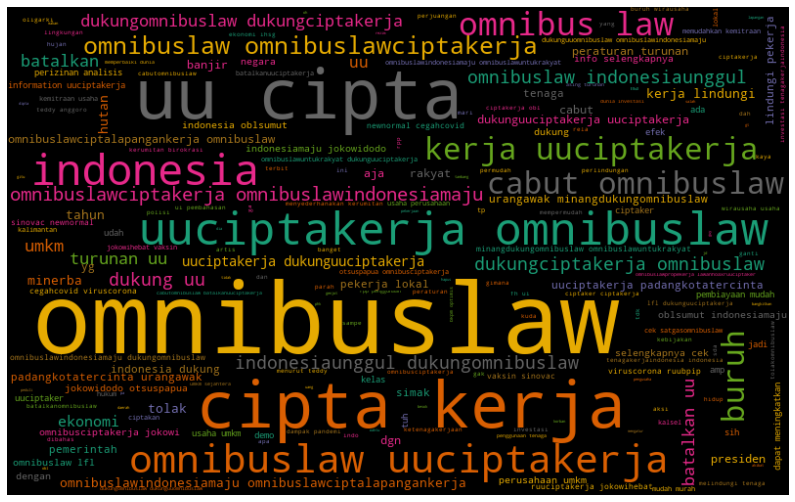

In [ ]:
generate_wordcloud(all_words)

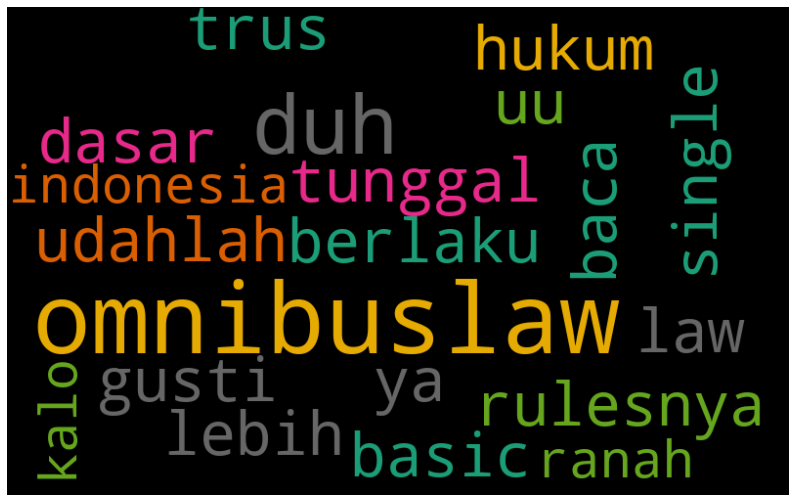

In [ ]:
all_words = ' '.join([text for text in tweets_df['absolute_clean_tweets'][tweets_df.Type == 'neg']])
generate_wordcloud(all_words)

In [ ]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags  
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()
    

In [ ]:
hashtags = hashtag_extract(tweets_df['clean_tweets'])
hashtags = sum(hashtags, [])

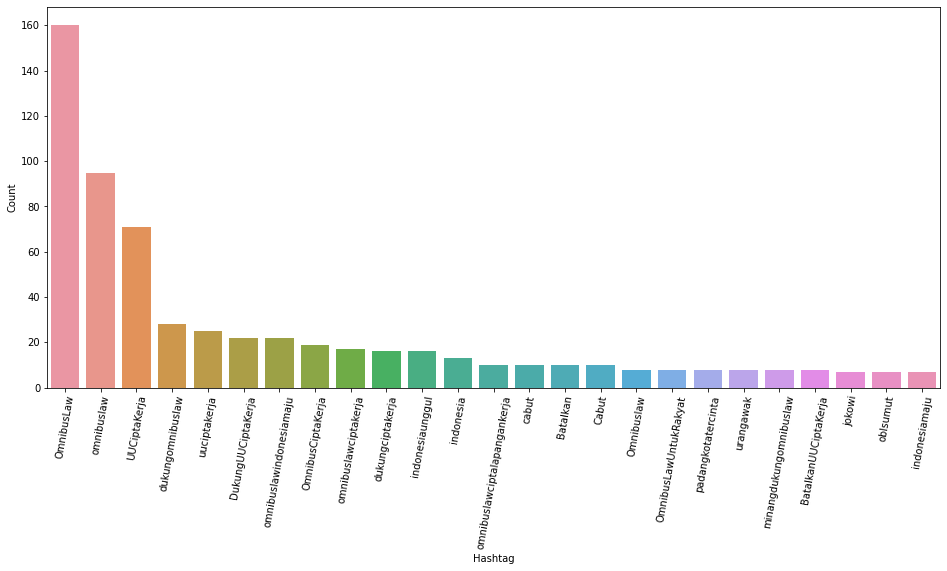

In [ ]:
generate_hashtag_freqdist(hashtags)

## Model Building (Unsupervised)

There are two major techniques for Sentiment Analsysis:- 



*   Supervised 
*   Unsupervised (Lexicon Based) 

Unsupervised way is generally useful when we do not have the convenience of well-labeled training dataset.

Here, I try to use unsupervised lexicon based approach based on **Vader lexicon** for sentiment analysis.



In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 7.2MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:

tweets_df = tweets_df.drop(['Type'], axis = 1)

In [ ]:
tweets_df['Compound_Score'] = [analyser.polarity_scores(x)['compound'] for x in tweets_df['clean_tweets']]

In [ ]:
tweets_df.head()

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu...",sarjana kontrak gajinya umr puyeng tenan apa e...,0.0000
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...,indonesian labour union are challenging the #o...,-0.4767
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...,peduli lingkungan ni yeeee tahu sih lingkungan...,0.0000
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,...",operasi senyap ld nasi kucing susu kuda liar s...,-0.5106
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee,tolak omnibuslaw besok dukung heheee,0.0000


In [ ]:
tweets_df.nlargest(10, ['Compound_Score']) 

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score
66,@sosirupa @SayaDajjaI @hs_meliala @Andiarief__...,Dan apa anda punya bukti perluasan itu akibat ...,dan bukti perluasan akibat omnibuslaw,0.9514
47,@sosirupa @SayaDajjaI @hs_meliala @Andiarief__...,🤣🤣🤣🤣 Belum...??? Katanya sejak omnibuslaw gila...,belum katanya omnibuslaw gilaan kok mencla men...,0.9237
68,@sosirupa @SayaDajjaI @hs_meliala @Andiarief__...,Mana datany setelah omnibuslaw..🤣🤣🤣🤣,mana datany omnibuslaw,0.9153
532,@Fahrihamzah @DPR_RI @DPDRI Memangnya masih pe...,Memangnya masih percaya dg yg mayoritas menyet...,memangnya percaya dg mayoritas menyetujui ruuh...,0.9153
371,Bebek-bebeknya yg ditengokin pas demo omnibusl...,Bebek-bebeknya yg ditengokin pas demo omnibusl...,bebekbebeknya ditengokin pa demo omnibuslaw am...,0.7184
25,Disahkannya UU Dipta Kerja \nWow! Ternyata Mem...,Disahkannya UU Dipta Kerja Wow! Ternyata Membe...,disahkannya uu dipta kerja wow ternyata member...,0.6239
35,Disahkannya UU Dipta Kerja \nWow! Ternyata Mem...,Disahkannya UU Dipta Kerja Wow! Ternyata Membe...,disahkannya uu dipta kerja wow ternyata member...,0.6239
40,Disahkannya UU Dipta Kerja \nWow! Ternyata Mem...,Disahkannya UU Dipta Kerja Wow! Ternyata Membe...,disahkannya uu dipta kerja wow ternyata member...,0.6239
27,UU Cipta Kerja Memperluas Kesempatan Kerja \nD...,UU Cipta Kerja Memperluas Kesempatan Kerja Dip...,uu cipta kerja memperluas kesempatan kerja dip...,0.5423
37,UU Cipta Kerja Memperluas Kesempatan Kerja \nD...,UU Cipta Kerja Memperluas Kesempatan Kerja Dip...,uu cipta kerja memperluas kesempatan kerja dip...,0.5423


In [ ]:
tweets_df.nsmallest(10, ['Compound_Score']) 

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score
267,@VeronicaPanlok1 Duh... Lebih tegas rulesnya d...,Duh... Lebih tegas rulesnya dari UU Omnibuslaw...,duh lebih rulesnya uu omnibuslaw,-0.6486
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,...",operasi senyap ld nasi kucing susu kuda liar s...,-0.5106
32,"@BennyKeef @jokowi Operasi senyap, tidak perlu...","Operasi senyap, tidak perlu ld, nasi kucing, s...",operasi senyap ld nasi kucing susu kuda liar s...,-0.5106
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...,indonesian labour union are challenging the #o...,-0.4767
326,"Gak bakalan ditindak, bahkan dg disahkannya UU...","Gak bakalan ditindak, bahkan dg disahkannya UU...",gak ditindak dg disahkannya uu no th pengusaha...,-0.4466
238,Indonesian labor unions are warning to expect ...,Indonesian labor unions are warning to expect ...,indonesian labor union are warning to expect t...,-0.3400
143,@convolute_n @WorldBank omnibuslaw salah satun...,omnibuslaw salah satunya na mah semakin di tra...,omnibuslaw salah satunya na mah trap middle in...,-0.3182
142,Nah ini untuk para wanita karir dan working mo...,Nah ini untuk para wanita karir dan working mo...,nah wanita karir working mom yuk simak fakta k...,-0.1759
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu...",sarjana kontrak gajinya umr puyeng tenan apa e...,0.0000
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...,peduli lingkungan ni yeeee tahu sih lingkungan...,0.0000


**Compund Score** is the most powerful metric for single unidimensional measure of sentiment for a given sentence. It is a 'normalized, weighted composite score computed by summing the valence scores of each word in lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1(most extreme positive) 

In [ ]:
tweets_df.loc[tweets_df['Compound_Score'] < -0.5, 'Sentiments'] = 'Negative' 
tweets_df.loc[(tweets_df['Compound_Score'] >= -0.5) & (tweets_df['Compound_Score'] < 0) , 'Sentiments'] = 'Slightly Negative' 
tweets_df.loc[tweets_df['Compound_Score'] == 0 , 'Sentiments'] = 'Neutral'
tweets_df.loc[(tweets_df['Compound_Score'] > 0) & (tweets_df['Compound_Score'] < 0.5), 'Sentiments'] = 'Slightly Positive'
tweets_df.loc[tweets_df['Compound_Score'] > 0.5 , 'Sentiments'] = 'Postive'
tweets_df

,tweets,clean_tweets,absolute_clean_tweets,Compound_Score,Sentiments
0,"@Innayaputri72 Sarjana saja kerja kontrak, gaj...","Sarjana saja kerja kontrak, gajinya pun UMR Pu...",sarjana kontrak gajinya umr puyeng tenan apa e...,0.0000,Neutral
1,Indonesian labour unions are challenging the #...,Indonesian labour unions are challenging the #...,indonesian labour union are challenging the #o...,-0.4767,Slightly Negative
2,@hipohan Peduli lingkungan ni yeeee... Tahu ap...,Peduli lingkungan ni yeeee... Tahu apa sih kam...,peduli lingkungan ni yeeee tahu sih lingkungan...,0.0000,Neutral
3,RT @annasantoz318: @BennyKeef @jokowi Operasi ...,": Operasi senyap, tidak perlu ld, nasi kucing,...",operasi senyap ld nasi kucing susu kuda liar s...,-0.5106,Negative
4,hari ini tolak omnibuslaw besok dukung heheee ...,hari ini tolak omnibuslaw besok dukung heheee,tolak omnibuslaw besok dukung heheee,0.0000,Neutral
...,...,...,...,...,...
555,GENJOT INVESTASI AER PENGANOGURAN TERATASI \nU...,GENJOT INVESTASI AEPENGANOGURAN TERATASI UU Ci...,genjot investasi aepenganoguran teratasi uu ci...,0.0000,Neutral
556,@mutiainsomnia @irgilian17 Dapet dana Dari pem...,Dapet dana Dari pemerintah ga buat kampanye om...,dapet dana dari pemerintah ga kampanye omnibuslaw,0.0000,Neutral
557,Negara Bisa Mengambil Alih Tanah-Tanah Terlant...,Negara Bisa Mengambil Alih Tanah-Tanah Terlant...,negara bisa mengambil alih tanahtanah terlanta...,0.0000,Neutral
558,3 RPP Lingkungan Hidup dan Kehutanan Masuk Tah...,3 RPP Lingkungan Hidup dan Kehutanan Masuk Tah...,rpp lingkungan hidup kehutanan masuk tahap har...,0.0000,Neutral


In [ ]:
tweets_df.to_csv('file.csv') 

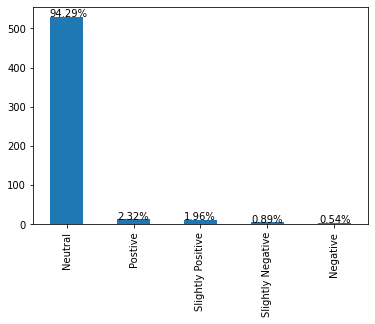

In [ ]:
s = pd.value_counts(tweets_df['Sentiments'])
ax = s.plot.bar()
n = len(tweets_df.index)

for p in ax.patches:
    ax.annotate(str(round(p.get_height() / n * 100, 2)) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))